In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import gridspec

xr.set_options(keep_attrs=True)


## Init dataset
dimension:
- time (01/01/2000 until from 01/12/2020)

In [161]:
time = pd.date_range(
        "01/2000",
        periods=20*12,
        freq=pd.DateOffset(months=1),
    )

amoc_dataset = xr.Dataset(
    data_vars=dict(),
    coords=dict(
        time=(["time"],time),
    ),
    attrs=dict(
        description="Aptherm Group Project to calculate the AMOC strength"
        ),
)


## Load datasets from all groups and adjust dimension names

In [162]:
DATAFOLDER = "data"

def RenameDimensionsAndVariables(dataset, dims_dict = dict(), vars_dict = False) :
    try:
        # rename the dimensions
        dataset = dataset.rename_dims(dims_dict)
        # rename coords assosiatet with dimensions
        try :
            dataset = dataset.rename_vars(dims_dict)
        except Exception as E :
            print(E)
        # rename the variables if necessary
        if vars_dict :
            dataset = dataset.rename_vars(vars_dict)
        return dataset
    except Exception as E :
        print(E)
        return None

# ============
# HYDROLOGICAL 
# group 1 and 2
hydrographic_mean = xr.open_dataset(DATAFOLDER + "/group1_mean_transport.nc")
hydrographic_mean = RenameDimensionsAndVariables(
            dataset = hydrographic_mean,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_mean"
                ))

hydrographic_climatology = xr.open_dataset(DATAFOLDER + "/group1_climatology_transport.nc")
hydrographic_climatology = RenameDimensionsAndVariables(
            dataset = hydrographic_climatology,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                TIME = "month"
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_climatology"
                ))

hydrographic_variability = xr.open_dataset(DATAFOLDER + "/group2_variability_interior_transport.nc")
hydrographic_variability = RenameDimensionsAndVariables(
            dataset = hydrographic_variability,
            dims_dict= 
            dict(
                lon = "longitude",
                p = "pressure",
            )
            )

# ============
# western boundary current
# group 3
western_boundary = xr.open_dataset(DATAFOLDER + "/group3_western_boundary_transport.nc")
western_boundary_monthly = western_boundary.resample(time="1MS").mean(dim="time")
western_boundary_monthly_std = western_boundary.resample(time="1MS").std(dim="time")

# ============
# ekman transport
# group 5
ekman_transport = xr.open_dataset(DATAFOLDER + "/group5_ekmann_transport.nc")

### Insert monthly ekman transport in Sv into the amoc dataset

In [163]:
amoc_dataset["ekman_transport"] = (1e-6*ekman_transport.volume_transport_y).where(ekman_transport.atlantic_mask).mean("latitude").sum('longitude')
amoc_dataset.ekman_transport.attrs = {
    ** ekman_transport.volume_transport_y.attrs,
    ** dict(
        long_name = 'ekman transport',
        label = 'ekman')
    }

### Create mean and std monthly transport of western boundary current

In [164]:
''' insert ekman_transport in Sv and westernboundary current to amoc dataset '''
western_boundary_attrs = dict(
    latitude = "11 deg S",
    longitude = "36 deg W - 34.8 deg W",
    depth = "0 - 2000 m",
    unit = "Sv",
    unit_full = "Sverdup are 1e6 m^3/s",
)
''' For the mean of the Western boundary transport it only makes a minor difference when to resample'''
print('Total difference in mean western boundary transport between adding before - after resample \n{:.3f} Sv'.format( 
        np.sum(( 
            western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").mean(dim="time") 
            - (western_boundary.Transport_pos.resample(time="1MS").mean(dim="time") + western_boundary.Transport_neg.resample(time="1MS").mean(dim="time"))
            ).values
        )
    )

'''No need for the single pos and neg. transport'''
# amoc_dataset['western_boundary_pos'] = western_boundary.Transport_pos.resample(time="1MS").mean(dim="time")
# amoc_dataset.western_boundary_pos.attrs = {
#         **western_boundary_attrs,
#         **dict(description = "Western boundary transport of the Brazil current in the upper layer towards the north",
#                 label = "Western boundary pos."
#                 )}

# amoc_dataset['western_boundary_neg'] = western_boundary.Transport_neg.resample(time="1MS").mean(dim="time")
# amoc_dataset.western_boundary_neg.attrs = {
#         **western_boundary_attrs,
#         **dict(description = "Western boundary transport of the Brazil under current in the lower layer towards the south",
#                 label = "Western boundary transport south"
#                 )}

amoc_dataset['western_boundary'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").mean(dim="time")
amoc_dataset.western_boundary.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport at 11 deg S",
                long_name = "Western boundary transport total",
                label = "WBT total"
                )}

'''regarding the std of the western boundary current there needs to be defined how to calulate it'''


print('Total difference in std of western boundary transport between adding before - after resample \n{:.3f} Sv'.format( 
        np.sum(( 
            western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").std(dim="time") 
            - (western_boundary.Transport_pos.resample(time="1MS").std(dim="time") + western_boundary.Transport_neg.resample(time="1MS").std(dim="time"))
            ).values
        )
    )
print('''regarding the std of the western boundary current there needs to be defined how to calulate it''')

# it is sufficient to calculate the standard deviation based on the combined transport, as they were both derived from the same dataset and are independent of each other.
# Thus the total std. is calc. after adding both.
amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time= "1MS").std("time")
amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos.resample(time="1MS").std(dim="time") + western_boundary.Transport_neg.resample(time="1MS").std(dim="time"))
amoc_dataset.western_boundary_std.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport monthly standard deviation from daily to monthly mean calculation",
                long_name = "Western boundary transport std",
                label = "WBT std"
                )}


Total difference in mean western boundary transport between adding before - after resample 
-0.178 Sv
Total difference in std of western boundary transport between adding before - after resample 
-108.315 Sv
regarding the std of the western boundary current there needs to be defined how to calulate it


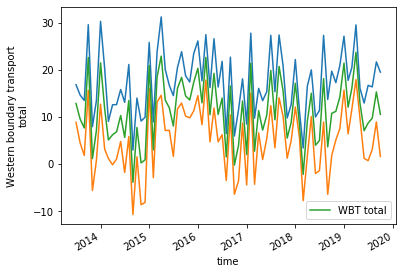

In [165]:
# quick plot of the western boundary transport
(amoc_dataset.western_boundary + amoc_dataset.western_boundary_std).plot()
(amoc_dataset.western_boundary - amoc_dataset.western_boundary_std).plot()
(amoc_dataset.western_boundary ).plot(label = amoc_dataset.western_boundary.attrs["label"])
plt.legend()


## Interior transport
1. add interior variability to the amoc dataset
2. calc interior mean from group1 and use it for amoc dataset

In [166]:
'''the total transport of the interior mean transport needs to be calculated'''
# 1. add temporal interior variability from group 2 to amoc dataset
'''determine that hydrographic_variablity wont be changed when transforming from mid of month to beginning of month'''
print(
    "The difference of interior variability before and after resample:\n{:.3f} Sv".format(
        np.sum(hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time").values - hydrographic_variability.integrated_transport.values)
    )
)
amoc_dataset['interior_variability'] = hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time")
amoc_dataset.interior_variability.attrs = {**amoc_dataset.interior_variability.attrs,
                **dict(
                    long_name = "Interior transport variability",
                    label = "Interior var."
                    )
                }
amoc_dataset

The difference of interior variability before and after resample:
0.000 Sv


<xarray.Dataset>
Dimensions:               (time: 240)
Coordinates:
  * time                  (time) datetime64[ns] 2000-01-01 ... 2019-12-01
Data variables:
    ekman_transport       (time) float32 nan nan nan nan nan ... nan nan nan nan
    western_boundary      (time) float64 nan nan nan nan ... 15.33 10.58 nan nan
    western_boundary_std  (time) float64 nan nan nan nan ... 6.367 8.948 nan nan
    interior_variability  (time) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Aptherm Group Project to calculate the AMOC strength

In [170]:
def plot_all_amoc_dataset(amoc_dataset, plot_kwargs) :
    for data_var in amoc_dataset :
        amoc_dataset[data_var].plot(label = amoc_dataset[data_var].attrs['label'], **plot_kwargs)
    plt.legend()

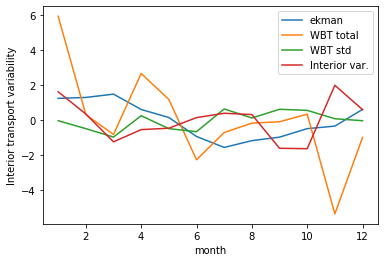

In [174]:
plot_all_amoc_dataset((amoc_dataset - amoc_dataset.mean()).groupby("time.month").mean("time"), plot_kwargs = dict(x = "month", linestyle = ""))

## Create a temporal plot and a seasonal cyle plot

In [180]:
fig = plt.figure(figsize= (16,6))
gs = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.4)
ax1 = fig.add_subplot(gs[:, 0:2])
ax2 = fig.add_subplot(gs[:, 2])

ax1.grid()
ax1.set_title("Meridional transport at 11°S")
ax1.set_xlabel(None)
ax1.set_ylabel("Transport [Sv]")

# for the second figure plot for each of the transport the seasonal cyle and for each month all the values as scatters
colors = ["tab:blue", "tab:orange", "tab:green", "tab:blue"]
for var, color in zip(amoc_dataset, colors) :
    
    ax2.plot(amoc_dataset[var].time, amoc_dataset[var],
                    alpha=0.2, color = color, zorder = 0)

    for year in np.unique(amoc_dataset.time.dt.year.values) :
        ax2.scatter(amoc_dataset[var].time.dt.month.values, 
                    amoc_dataset[var].where(amoc_dataset[var].time.dt.year == year).values,
                    alpha=0.2, color= color , zorder = 0, marker = "x")
    
# ax2.fill_between(ekmantransport_11S.groupby("time.month").median(dim = "time").month,
#     ekmantransport_11S.sum("longitude").groupby("time.month").quantile(0.05, dim = "time"),
#     ekmantransport_11S.sum("longitude").groupby("time.month").quantile(0.95, dim = "time"),
#     alpha = 0.05, color = "k", edgecolor = "",
#     zorder = 1
#     )
# ax2.fill_between(ekmantransport_11S.groupby("time.month").median(dim = "time").month,
#     ekmantransport_11S.sum("longitude").groupby("time.month").quantile(0.33, dim = "time"),
#     ekmantransport_11S.sum("longitude").groupby("time.month").quantile(0.66, dim = "time"),
#     alpha = 0.1, color = "k", edgecolor = "",
#     zorder = 1)
ax2.grid()
ax2.set_title("Meridional ekman volume \ntransport at 11°S - seasonal cycle")
ax2.set_xlabel("Month")
ax2.set_ylabel("Ekman Transport [Sv]")
ax2.legend()


for axs in [ax1,ax2] :
    axs.set_ylim(-10,-2.5)

# fig.savefig(PLOTFOLDER + "11S_Transport.svg") #, dpi = 400)

No handles with labels found to put in legend.


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000011B8831FB70> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

ValueError: view limit minimum -46718.9409242505 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units